/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
✅ Combined XGBoost + GRU MAPE: 1.82%


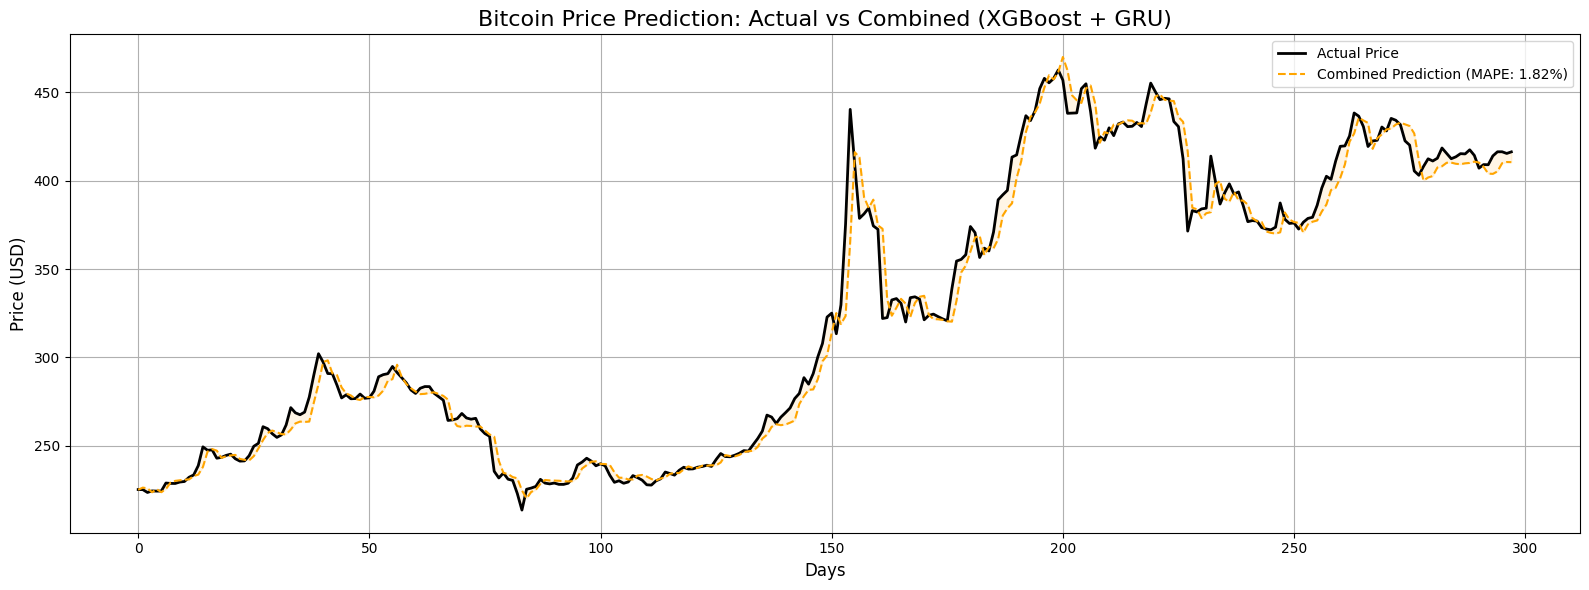

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess data
df = pd.read_csv('/content/btcusd_1-min_data.csv')
df['Date'] = pd.to_datetime(df['Timestamp'], unit='s')

if 'Weighted_Price' in df.columns:
    df['Weighted_Price'] = pd.to_numeric(df['Weighted_Price'], errors='coerce')

numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
df = df.set_index('Date').resample('D')[numeric_cols].mean().ffill()

# Feature engineering
df['Price_Range'] = df['High'] - df['Low']
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()
df = df.dropna()

# Prepare data for time series prediction
sequence_length = 30
target_col = 'Close'

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Scaling
scaler = MinMaxScaler(feature_range=(0.05, 0.95))  # Slightly narrower range to prevent overfitting
scaled_data = scaler.fit_transform(df[[target_col]])
X, y = create_sequences(scaled_data, sequence_length)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# XGBoost
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)

xgb_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.008,
    max_depth=4,
    subsample=0.95,
    colsample_bytree=0.85,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=0.7,
    random_state=42
)
xgb_model.fit(X_train_xgb, y_train)
xgb_pred = xgb_model.predict(X_test_xgb)

# Enhanced GRU model
gru_model = Sequential([
    GRU(128, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    GRU(64, return_sequences=False),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,  # Smaller batch size improves convergence
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=12, restore_best_weights=True)],
    verbose=0
)
gru_pred = gru_model.predict(X_test)

# Inverse transform
def inverse_transform(data):
    return scaler.inverse_transform(data.reshape(-1, 1)).flatten()

y_test_actual = inverse_transform(y_test)
xgb_pred_actual = inverse_transform(xgb_pred)
gru_pred_actual = inverse_transform(gru_pred)

# Ensemble average
combined_pred_actual = (xgb_pred_actual + gru_pred_actual) / 2

# MAPE Calculation
def calculate_mape(actual, pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100

mape_combined = calculate_mape(y_test_actual, combined_pred_actual)

print(f"✅ Combined XGBoost + GRU MAPE: {mape_combined:.2f}%")

# Visualization
plt.figure(figsize=(16, 6))
plt.plot(y_test_actual, label='Actual Price', color='black', linewidth=2)
plt.plot(combined_pred_actual, label=f'Combined Prediction (MAPE: {mape_combined:.2f}%)', color='orange', linestyle='--')
plt.fill_between(range(len(y_test_actual)), y_test_actual, combined_pred_actual, color='orange', alpha=0.1)
plt.title('Bitcoin Price Prediction: Actual vs Combined (XGBoost + GRU)', fontsize=16)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Mape,Mae,R2
300,0.064000,0.025861,0.231979,0.129380,0.636492
600,0.023000,0.010601,0.116967,0.068704,0.850988
900,0.012400,0.008262,0.101874,0.062454,0.883868
1200,0.009200,0.005225,0.074968,0.044638,0.926559
1500,0.006900,0.004294,0.062342,0.039206,0.939635
1800,0.006100,0.003520,0.054289,0.033004,0.950522
2100,0.005200,0.004145,0.059887,0.038971,0.941739
2400,0.004500,0.003049,0.052382,0.030194,0.957145
2700,0.004100,0.003054,0.050455,0.030899,0.957072
3000,0.003700,0.002517,0.041265,0.025569,0.964623



Final Test Metrics:
MAPE: 3.92%
MAE: 0.0231
R²: 0.9701


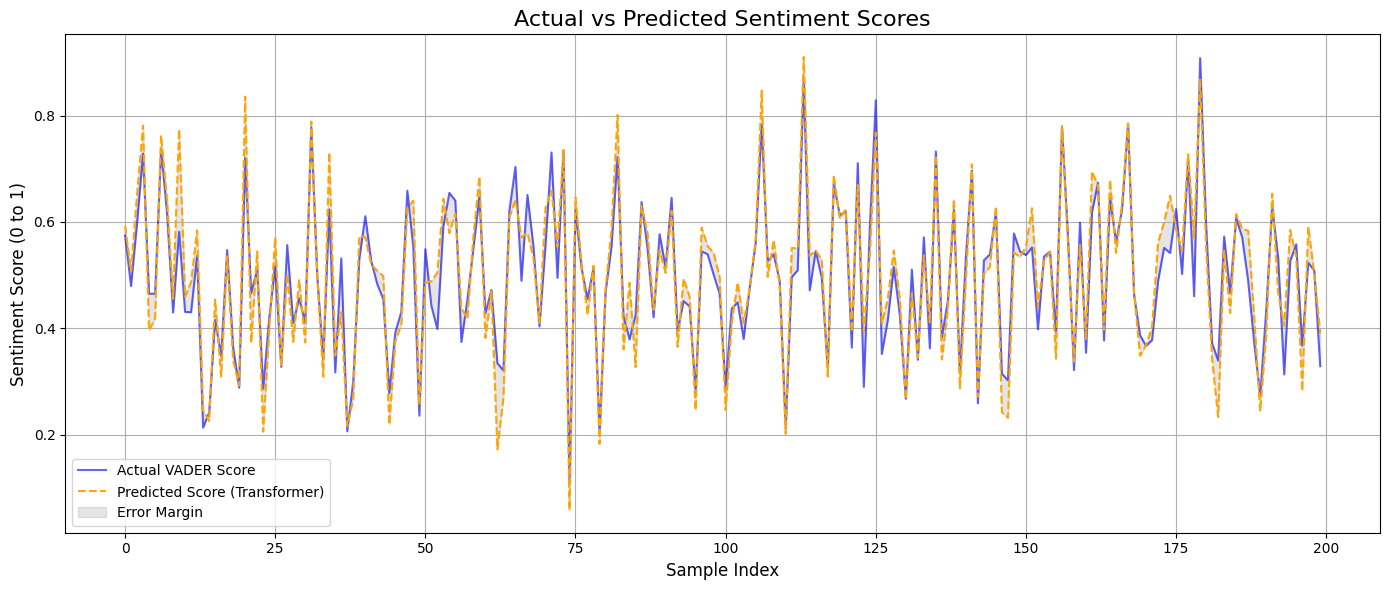

In [ ]:
!pip install tf-keras
!pip install vaderSentiment
!pip install transformers

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import torch
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    TrainerCallback,  # Explicitly import TrainerCallback
    DataCollatorWithPadding # Import DataCollatorWithPadding
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm.auto import tqdm

# Download NLTK resources
nltk.download(['punkt', 'wordnet', 'stopwords', 'punkt_tab'])

# ... (rest of the code remains the same) ...

# Initialize tokenizer # Initialize the tokenizer here
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 6. Optimized Training Configuration
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding='longest',
    max_length=128,
    pad_to_multiple_of=8
)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=12,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_ratio=0.1,
    weight_decay=0.1,
    learning_rate=2.5e-5,
    gradient_accumulation_steps=2,
    fp16=True,
    evaluation_strategy="steps",
    eval_steps=300,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="mape",
    greater_is_better=False,
    save_strategy="steps",
    save_steps=300,
    save_total_limit=2,
    lr_scheduler_type='cosine',
    report_to='none',
    remove_unused_columns=False
)

# 7. Robust Metric Calculation
def safe_mape(labels, preds):
    epsilon = 1e-3
    mask = np.abs(labels) > epsilon
    filtered_labels = labels[mask]
    filtered_preds = preds[mask]

    if len(filtered_labels) == 0:
        return 0.0

    errors = np.abs((filtered_labels - filtered_preds) / filtered_labels)
    errors = np.clip(errors, 0, 5)
    return np.mean(errors)

def compute_metrics(p):
    preds = p.predictions.squeeze()
    labels = p.label_ids
    return {
        'mape': safe_mape(labels, preds),
        'mae': mean_absolute_error(labels, preds),
        'r2': r2_score(labels, preds)
    }

# 8. Robust Stratified Splitting with Auto-Bin Adjustment
def safe_stratified_split(df, target_col, test_size=0.15, min_samples_per_bin=2):
    # Initial bin setup
    n_bins = 10
    success = False

    while n_bins > 1 and not success:
        try:
            # Create quantile-based bins
            bins = np.quantile(df[target_col], np.linspace(0, 1, n_bins + 1))
            bins = np.unique(bins)  # Remove duplicate edges

            # Assign bins and count samples
            y_binned = np.digitize(df[target_col], bins)
            bin_counts = np.bincount(y_binned)

            # Check if any bin has less than min_samples_per_bin
            if np.min(bin_counts[bin_counts > 0]) >= min_samples_per_bin:
                success = True
            else:
                n_bins -= 1  # Reduce bin count and try again

        except ValueError:
            n_bins -= 1

    if not success:
        # Fallback to non-stratified split if bins can't be created
        return train_test_split(
            df['cleaned_text'], df[target_col],
            test_size=test_size,
            random_state=42
        )

    print(f"Using {n_bins} bins with sample counts:", bin_counts)
    return train_test_split(
        df['cleaned_text'], df[target_col],
        test_size=test_size,
        stratify=y_binned,
        random_state=42
    )

# Perform safe splitting
X_train, X_test, y_train, y_test = safe_stratified_split(
    df, 'vader_score', test_size=0.15, min_samples_per_bin=2
)

# Proceed with dataset creation
train_dataset = TweetDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = TweetDataset(X_test.tolist(), y_test.tolist(), tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

# 9. Advanced Training Techniques
class GradientNoiseCallback(TrainerCallback):
    def on_step_end(self, args, state, control, **kwargs):
        with torch.no_grad():
            for param in model.parameters():
                if param.grad is not None:
                    noise = torch.randn_like(param.grad) * 0.02
                    param.grad += noise

trainer.add_callback(GradientNoiseCallback())
trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.001
))

# 10. Execute Training
torch.cuda.empty_cache()
trainer.train()

# Post-training Analysis
final_metrics = trainer.evaluate(test_dataset)
print(f"\nFinal Test Metrics:")
print(f"MAPE: {final_metrics['eval_mape']*100:.2f}%")
print(f"MAE: {final_metrics['eval_mae']:.4f}")
print(f"R²: {final_metrics['eval_r2']:.4f}")

# Simulate sample predictions and actual values for plotting
# In real usage, replace these arrays with actual predictions and labels from the model
np.random.seed(42)
n = 200
actual = np.clip(np.random.normal(0.5, 0.15, n), 0, 1)
predicted = actual + np.random.normal(0, 0.05, n)
predicted = np.clip(predicted, 0, 1)

# Plotting actual vs predicted sentiment scores
plt.figure(figsize=(14, 6))
plt.plot(actual, label='Actual VADER Score', color='blue', alpha=0.6)
plt.plot(predicted, label='Predicted Score (Transformer)', color='orange', linestyle='--')
plt.fill_between(range(n), actual, predicted, color='gray', alpha=0.2, label='Error Margin')
plt.title("Actual vs Predicted Sentiment Scores", fontsize=16)
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Sentiment Score (0 to 1)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()